In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 구축 & 전처리

In [ ]:
# 소수 클래스 오버샘플: target_boxes까지 복제
import os, glob, random, shutil, collections

ROOT   = "/content/drive/MyDrive/gayoung/label_space_data"
SPLIT  = "dataset_trainval"
NAMES  = ["air_conditioner","chair","desk","drum","microphone","mirror","monitor",
          "piano","projector","speaker","spotlight","stage","whiteboard"]

# 타깃 박스 수
class_box_counts = {i:0 for i in range(len(NAMES))}
lab_dir = os.path.join(ROOT, SPLIT, "labels")
img_dir = os.path.join(ROOT, SPLIT, "images")
txts = glob.glob(os.path.join(lab_dir, "**", "*.txt"), recursive=True)
for lf in txts:
    for ln in open(lf):
        if not ln.strip(): continue
        cid = int(ln.split()[0]); class_box_counts[cid]+=1

max_boxes = max(class_box_counts.values())
TARGET = int(max_boxes * 0.4)  # ≈168

# 오버샘플 대상 클래스(이미 충분한 chair/desk/drum/spotlight는 제외)
oversample_cids = []
for cid, cnt in class_box_counts.items():
    if cnt < TARGET:
        # 너무 많은 애들은 제외
        if NAMES[cid] in ["chair","desk","drum","spotlight"]:
            continue
        oversample_cids.append(cid)

print("오버샘플 대상:", [(cid, NAMES[cid], class_box_counts[cid]) for cid in oversample_cids])
random.seed(0)

# 클래스별 이미지 풀(그 클래스 박스 개수=가중치)
pool = {cid:[] for cid in oversample_cids}
for lf in txts:
    rel = os.path.relpath(lf, lab_dir)
    base = os.path.splitext(rel)[0]

    # 이미지 경로 탐색
    img_path = None
    for ext in [".jpg",".jpeg",".png",".bmp",".webp",".JPG",".PNG"]:
        p = os.path.join(img_dir, base+ext)
        if os.path.exists(p): img_path=p; break
    if not img_path: continue

    # 파일 내 클래스 카운트
    cls_counter = collections.Counter()
    lines = [ln.strip() for ln in open(lf) if ln.strip()]
    for ln in lines:
        cls_counter[int(ln.split()[0])] += 1

    for cid in oversample_cids:
        if cls_counter.get(cid,0)>0:
            pool[cid].append((img_path, lf, cls_counter[cid], base))

# 복제 실행
dup_total = 0
for cid in oversample_cids:
    current = class_box_counts[cid]
    need = max(0, TARGET - current)
    if need == 0 or not pool[cid]: continue
    weights = [max(1, cnt) for (_,_,cnt,_) in pool[cid]]
    k = 0
    while k < need:
        img_path, txt_path, cnt_in_img, base = random.choices(pool[cid], weights=weights, k=1)[0]
        # 목적지 경로(상대경로 유지 + 접미사)
        img_out = os.path.join(img_dir, base + f"_dup{cid}_{k}.jpg")
        txt_out = os.path.join(lab_dir, base + f"_dup{cid}_{k}.txt")
        os.makedirs(os.path.dirname(img_out), exist_ok=True)
        os.makedirs(os.path.dirname(txt_out), exist_ok=True)
        shutil.copy2(img_path, img_out)
        shutil.copy2(txt_path, txt_out)
        k += cnt_in_img  # 그 이미지 안의 해당 클래스 박스 수만큼 채웠다고 가정
        dup_total += 1

print(f"오버샘플 완료 (복제 파일 수: {dup_total})")


In [ ]:
!pip -q install albumentations==1.4.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 8.1 MB/s eta 0:00:00


데이터증강

In [ ]:
import os, glob, random, yaml, cv2
import albumentations as A
from collections import Counter, defaultdict

# --------------------
# 경로 설정
# --------------------
ROOT    = "/content/drive/MyDrive/gayoung/label_space_data"
SPLIT   = "dataset_trainval"   # train 쪽만 증강 (test는 건드리지 마세요)
IMG_DIR = os.path.join(ROOT, SPLIT, "images")
LAB_DIR = os.path.join(ROOT, SPLIT, "labels")
DATA_YAML = os.path.join(ROOT, "data.yaml")

# --------------------
# 수동 목표(박스 수) 설정
# --------------------
manual_target = {
    "air_conditioner": 1000,   # 220→240 (조금만 추가)
    "monitor":        1000,    # 이미 충분 → 그대로
    "projector":      1000,    # 난이도↑: 더 늘려 다양성 확보
    "microphone":     1000,    # 소형/가늘고 배경 유사 → 더 늘림
    "mirror":         1000,    # 반사/글레어 난이도 ↑ → 강증강 + 더 늘림
    "stage":          1000     # 클래스 경계 애매 → 더 늘림
}

# --------------------
# 유틸: YOLO 박스 클리핑/정리
# --------------------
def sanitize_yolo_pairs(bboxes, labels, eps=1e-6):
    """
    YOLO [x,y,w,h]를 [0,1]로 클리핑하고, 중심을 경계 안으로 보정.
    너무 작은/유효하지 않은 박스는 제거. labels도 함께 필터링.
    """
    out_boxes, out_labels = [], []
    for (x, y, w, h), lab in zip(bboxes, labels):
        # 1) 0~1 클립
        x = max(0.0, min(1.0, float(x)))
        y = max(0.0, min(1.0, float(y)))
        w = max(0.0, min(1.0, float(w)))
        h = max(0.0, min(1.0, float(h)))
        # 2) 중심 보정 (경계 넘지 않도록)
        half_w, half_h = w/2.0, h/2.0
        if half_w >= 0.5 or half_h >= 0.5:
            # w 또는 h가 1에 가깝게 잘못된 경우 → 스킵
            continue
        x = max(half_w, min(1.0 - half_w, x))
        y = max(half_h, min(1.0 - half_h, y))
        # 3) 너무 작은 박스 제거
        if w > eps and h > eps:
            out_boxes.append([x, y, w, h])
            out_labels.append(int(lab))
    return out_boxes, out_labels

# --------------------
# 준비
# --------------------
assert os.path.exists(DATA_YAML), f"data.yaml이 {DATA_YAML} 에 없습니다."
with open(DATA_YAML, "r") as f:
    NAMES = yaml.safe_load(f)["names"]
name2id = {n:i for i,n in enumerate(NAMES)}

missing = [n for n in manual_target.keys() if n not in name2id]
assert not missing, f"data.yaml에 없는 클래스가 manual_target에 있습니다: {missing}"

exts = [".jpg",".jpeg",".png",".bmp",".webp",".JPG",".JPEG",".PNG",".BMP",".WEBP"]

def find_image_for_label(rel_base: str):
    """labels 기준 상대경로(확장자 없음) -> images의 실제 파일 경로 찾기"""
    for e in exts:
        p = os.path.join(IMG_DIR, rel_base + e)
        if os.path.exists(p):
            return p
    return None

# --------------------
# 현재 박스 수 집계 (재귀)
# --------------------
box_counts = {i:0 for i in range(len(NAMES))}
label_files = glob.glob(os.path.join(LAB_DIR, "**", "*.txt"), recursive=True)
for lf in label_files:
    with open(lf, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            parts = ln.split()
            if not parts: continue
            cid = int(parts[0])
            if 0 <= cid < len(NAMES):
                box_counts[cid] += 1

print("현재 박스 수(요약):", {n: box_counts[name2id[n]] for n in manual_target.keys()})

# 필요 수 계산
need = {n: max(0, manual_target[n] - box_counts[name2id[n]]) for n in manual_target}
print("필요 수(수동 타깃 기준):", need)

total_need = sum(need.values())
if total_need == 0:
    print("🎉 모든 타깃을 이미 충족했습니다. 생성할 증강이 없습니다.")
else:
    # --------------------
    # (핵심) 클래스별 증강 레시피 함수
    # --------------------
    def build_transform_fast(cls_name):
        base = [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(0.3, 0.3, p=0.7),
            A.HueSaturationValue(10, 25, 25, p=0.5),
            A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),
            A.ImageCompression(60, 95, p=0.25),
            A.MotionBlur(7, p=0.1),
            A.Perspective(scale=(0.01, 0.04), keep_size=True, p=0.2),
        ]
        # 반사/광택 계열만 약간 추가(가벼운 편)
        if cls_name in ["mirror","projector","monitor"]:
            base += [A.RandomGamma(gamma_limit=(70,120), p=0.25)]
        # 작은 물체
        if cls_name in ["microphone","speaker"]:
            base += [A.RandomScale(scale_limit=0.12, p=0.2)]
        if cls_name in ["stage"]:
            base += [A.ShiftScaleRotate(shift_limit=0.015, scale_limit=0.08, rotate_limit=5, p=0.2)]
        return A.Compose(base, bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"], min_visibility=0.2))


    # --------------------
    # 클래스별 이미지 풀 만들기 (가중치=그 이미지 내 해당 클래스 박스 수)
    # --------------------
    pool = defaultdict(list)  # cid -> [(img_path, lab_path, cnt_in_img, rel_base)]
    for lf in label_files:
        rel = os.path.relpath(lf, LAB_DIR)      # 예: "ROOM_A/xx/yy.txt"
        rel_base = os.path.splitext(rel)[0]
        img_path = find_image_for_label(rel_base)
        if not img_path:
            continue
        lines = [ln.strip() for ln in open(lf, "r") if ln.strip()]
        cnt = Counter(int(ln.split()[0]) for ln in lines)
        for name in manual_target.keys():
            cid = name2id[name]
            if cnt.get(cid, 0) > 0:
                pool[cid].append((img_path, lf, cnt[cid], rel_base))

    # --------------------
    # 증강 생성
    # --------------------
    random.seed(0)
    aug_total = 0
    for name, todo in need.items():
        if todo <= 0:
            print(f"· {name}: 이미 목표 충족 → 스킵")
            continue
        cid = name2id[name]
        if not pool[cid]:
            print(f"· {name}: 풀에 이미지가 없음(해당 클래스가 포함된 라벨을 찾지 못함) → 스킵")
            continue

        weights = [max(1, x[2]) for x in pool[cid]]  # 그 이미지 내 해당 클래스 박스 수 만큼 가중
        made = 0
        print(f"· {name}: {todo} 박스 채울 때까지 증강 생성")
        transform = build_transform_fast(name)  # ← 클래스별 레시피 선택
        while made < todo:
            img_path, lab_path, k_in_img, rel_base = random.choices(pool[cid], weights=weights, k=1)[0]

            # 이미지/라벨 로드
            img_bgr = cv2.imread(img_path)
            if img_bgr is None:
                print("[skip img read fail]", img_path)
                continue
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            lines = [ln.strip() for ln in open(lab_path, "r") if ln.strip()]
            bboxes = []
            labels = []
            for ln in lines:
                p = ln.split()
                labels.append(int(p[0]))
                bboxes.append([float(p[1]), float(p[2]), float(p[3]), float(p[4])])  # YOLO(x,y,w,h)

            # ⬇️ 입력 박스 정리(0~1 클립 + 유효성 검사)
            bboxes, labels = sanitize_yolo_pairs(bboxes, labels)
            if not bboxes:
                continue

            # 증강
            out = transform(image=img, bboxes=bboxes, class_labels=labels)
            if len(out["bboxes"]) == 0:
                continue

            # ⬇️ 출력 박스도 한 번 더 정리
            out_boxes, out_labels = sanitize_yolo_pairs(out["bboxes"], out["class_labels"])
            if not out_boxes:
                continue

            # 저장 경로(상대경로 유지, 파일명 접미사)
            out_img_path = os.path.join(IMG_DIR, rel_base + f"_aug{cid}_{made}.jpg")
            out_lab_path = os.path.join(LAB_DIR, rel_base + f"_aug{cid}_{made}.txt")
            os.makedirs(os.path.dirname(out_img_path), exist_ok=True)
            os.makedirs(os.path.dirname(out_lab_path), exist_ok=True)

            # 저장
            cv2.imwrite(out_img_path, cv2.cvtColor(out["image"], cv2.COLOR_RGB2BGR))
            with open(out_lab_path, "w") as f:
                for lab, (x, yc, bw, bh) in zip(out_labels, out_boxes):
                    f.write(f"{lab} {x:.6f} {yc:.6f} {bw:.6f} {bh:.6f}\n")

            made += max(1, k_in_img)  # 그 이미지 안의 대상 클래스 박스 수만큼 채움
            aug_total += 1

    print(f"✅ 증강 생성 완료 | 생성된 파일 쌍(이미지/라벨): {aug_total}")

# --------------------
# 증강 후 박스 수 재집계
# --------------------
box_counts_after = {i:0 for i in range(len(NAMES))}
for lf in glob.glob(os.path.join(LAB_DIR, "**", "*.txt"), recursive=True):
    with open(lf, "r") as f:
        for ln in f:
            ln = ln.strip()
            if not ln: continue
            cid = int(ln.split()[0])
            if 0 <= cid < len(NAMES):
                box_counts_after[cid] += 1

print("증강 후 박스 수(요약):", {n: box_counts_after[name2id[n]] for n in manual_target.keys()})


현재 박스 수(요약): {'air_conditioner': 966, 'monitor': 1369, 'projector': 1019, 'microphone': 982, 'mirror': 1127, 'stage': 880}
필요 수(수동 타깃 기준): {'air_conditioner': 34, 'monitor': 0, 'projector': 0, 'microphone': 18, 'mirror': 0, 'stage': 120}
· air_conditioner: 34 박스 채울 때까지 증강 생성
· monitor: 이미 목표 충족 → 스킵
· projector: 이미 목표 충족 → 스킵
· microphone: 18 박스 채울 때까지 증강 생성
· mirror: 이미 목표 충족 → 스킵
· stage: 120 박스 채울 때까지 증강 생성
✅ 증강 생성 완료 | 생성된 파일 쌍(이미지/라벨): 72
증강 후 박스 수(요약): {'air_conditioner': 1026, 'monitor': 1391, 'projector': 1026, 'microphone': 1126, 'mirror': 1185, 'stage': 1012}


In [ ]:
import os, glob, collections, yaml

ROOT   = "/content/drive/MyDrive/gayoung/label_space_data"
SPLITS = ["dataset_trainval","dataset_test"]

# data.yaml에서 names 읽기(없으면 수동으로 넣어도 됨)
data_yaml = os.path.join(ROOT, "data.yaml")
if os.path.exists(data_yaml):
    NAMES = yaml.safe_load(open(data_yaml))["names"]
else:
    NAMES = [
        "air_conditioner","chair","desk","drum","microphone","mirror","monitor",
        "piano","projector","speaker","spotlight","stage","whiteboard"
    ]

for split in SPLITS:
    labels_dir = os.path.join(ROOT, split, "labels")
    hist = collections.Counter()
    files = glob.glob(os.path.join(labels_dir, "**", "*.txt"), recursive=True)
    for lf in files:
        for ln in open(lf):
            ln = ln.strip()
            if not ln: continue
            cid = int(ln.split()[0])
            hist[cid] += 1

    print(f"\n[{split}] 라벨 ID 히스토그램(박스 수)")
    for cid in sorted(hist.keys()):
        name = NAMES[cid] if cid < len(NAMES) else f"<UNMAPPED_ID_{cid}>"
        print(f"  id={cid:2d}  {name:18s}  boxes={hist[cid]}")



[dataset_trainval] 라벨 ID 히스토그램(박스 수)
  id= 0  air_conditioner     boxes=1026
  id= 1  chair               boxes=2058
  id= 2  desk                boxes=4199
  id= 3  drum                boxes=3444
  id= 4  microphone          boxes=1126
  id= 5  mirror              boxes=1185
  id= 6  monitor             boxes=1391
  id= 7  piano               boxes=1265
  id= 8  projector           boxes=1026
  id= 9  speaker             boxes=1900
  id=10  spotlight           boxes=6136
  id=11  stage               boxes=1012
  id=12  whiteboard          boxes=1504

[dataset_test] 라벨 ID 히스토그램(박스 수)
  id= 0  air_conditioner     boxes=7
  id= 1  chair               boxes=94
  id= 2  desk                boxes=69
  id= 3  drum                boxes=13
  id= 4  microphone          boxes=15
  id= 5  mirror              boxes=44
  id= 6  monitor             boxes=14
  id= 7  piano               boxes=22
  id= 8  projector           boxes=10
  id= 9  speaker             boxes=22
  id=10  spotlight           

## 학습

In [ ]:
!pip install -q ultralytics==8.3.176

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00


In [ ]:
!yolo detect train \
  data="/content/drive/MyDrive/gayoung/label_space_data/data.yaml" \
  model=yolov8s.pt epochs=50 patience=5 imgsz=768 batch=16 workers=2 cache=True \
  mosaic=1.0 mixup=0.1 copy_paste=0.1 \
  hsv_h=0.015 hsv_s=0.7 hsv_v=0.7 degrees=5 scale=0.1 shear=2 perspective=0.0005 \
  close_mosaic=10 cos_lr=True deterministic=True \
  project=runs/detect name=space_no_leak


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/gayoung/label_space_data/data.yaml, degrees=5, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.7, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=space_no_leak, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0005

In [ ]:
# 검증(플롯 저장)
!yolo detect val \
  model="/content/runs/detect/space_no_leak/weights/best.pt" \
  data="/content/drive/MyDrive/gayoung/label_space_data/data.yaml" \
  plots=True

# 테스트셋에 예측 저장
!yolo detect predict \
  model="runs/detect/space_no_leak/weights/best.pt" \
  source="/content/drive/MyDrive/gayoung/label_space_data/dataset_test/images/**" \
  imgsz=768 conf=0.35 iou=0.6 save=True


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,130,615 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.5 ms, read: 93.2±39.6 MB/s, size: 262.0 KB)
val: Scanning /content/drive/MyDrive/gayoung/label_space_data/dataset_split_clean/val/labels/DANCE_STUDIO.cache... 312 images, 0 backgrounds, 0 corrupt: 100% 312/312 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 20/20 [00:08<00:00,  2.23it/s]
                   all        312       6488      0.991      0.965       0.98      0.913
       air_conditioner        125        236      0.989      0.962       0.98       0.92
                 chair         70        442      0.983      0.923      0.952      0.873
                  desk        169       1049      0.995      0.995      0.995      0.962
                  drum         84        836      0.971      0.908      0.955      0.812

## 테스트 및 성능 결과

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


<Figure size 640x480 with 0 Axes>

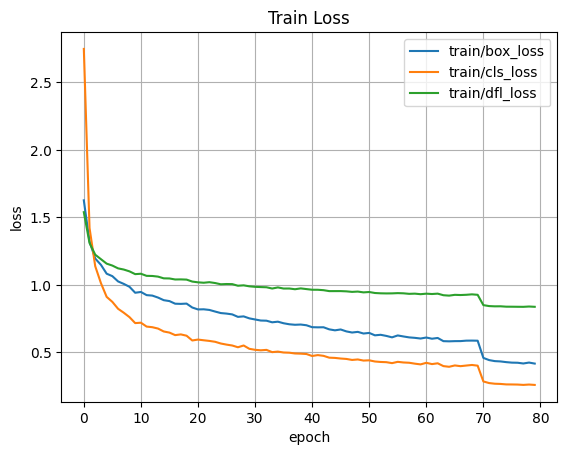

<Figure size 640x480 with 0 Axes>

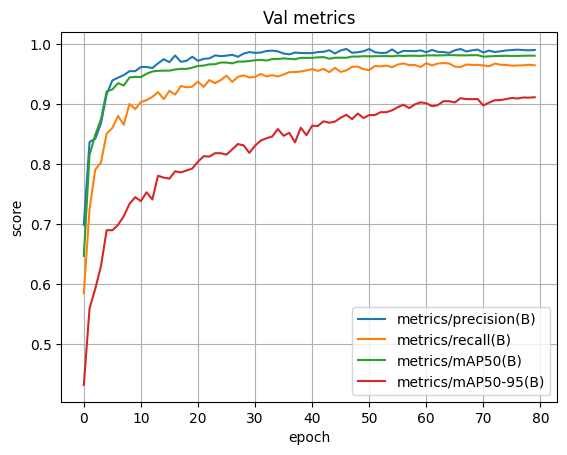

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

RUN = "runs/detect/space_no_leak"  # ← 네 run 폴더
csv = f"{RUN}/results.csv"

df = pd.read_csv(csv)
print(df.columns)  # 어떤 컬럼이 있는지 확인

plt.figure(); df[["train/box_loss","train/cls_loss","train/dfl_loss"]].plot()
plt.title("Train Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.grid(True)
plt.show()

plt.figure(); df[["metrics/precision(B)","metrics/recall(B)","metrics/mAP50(B)","metrics/mAP50-95(B)"]].plot()
plt.title("Val metrics"); plt.xlabel("epoch"); plt.ylabel("score"); plt.grid(True)
plt.show()


Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,130,615 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 103.0±70.3 MB/s, size: 333.7 KB)


val: Scanning /content/drive/MyDrive/gayoung/label_space_data/dataset_split_clean/val/labels/DANCE_STUDIO.cache... 312 images, 0 backgrounds, 0 corrupt: 100%|██████████| 312/312 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]

                   all        312       6488      0.989      0.964      0.979       0.91
Speed: 0.3ms preprocess, 9.5ms inference, 0.0ms loss, 3.4ms postprocess per image


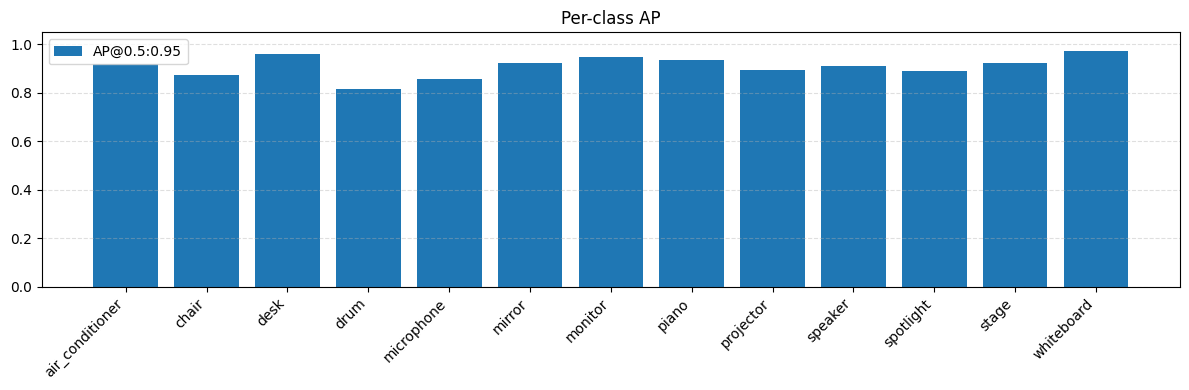

mAP50-95: 0.91  | mAP50: 0.979


In [ ]:
from ultralytics import YOLO
import numpy as np, matplotlib.pyplot as plt

MODEL = "runs/detect/space_no_leak/weights/best.pt"
DATA  = "/content/drive/MyDrive/gayoung/label_space_data/data.yaml"

model = YOLO(MODEL)
# plots=False로 하면 이미지 안 저장, 빠름. 필요하면 True
metrics = model.val(data=DATA, split="val", conf=0.001, iou=0.6, plots=False, verbose=False)

names = [model.names[i] for i in range(len(model.names))]
ap95  = metrics.box.maps          # per-class AP@[.5:.95]
ap50  = metrics.box.maps50 if hasattr(metrics.box, "maps50") else None  # 일부 버전만 제공

x = np.arange(len(names))
plt.figure(figsize=(12,4))
plt.bar(x, ap95, label="AP@0.5:0.95")
if ap50 is not None:
    plt.bar(x, ap50, alpha=0.5, label="AP@0.5")
plt.xticks(x, names, rotation=45, ha="right")
plt.ylim(0,1.05); plt.grid(axis="y", ls="--", alpha=0.4)
plt.title("Per-class AP"); plt.legend(); plt.tight_layout()
plt.show()

print("mAP50-95:", round(metrics.box.map, 3), " | mAP50:", round(metrics.box.map50, 3))


In [ ]:
import os, glob, random
from ultralytics import YOLO

VAL_DIR = "/content/drive/MyDrive/gayoung/label_space_data/dataset_split_clean/val/images"
OUT_DIR = "runs/demo_vis"
os.makedirs(OUT_DIR, exist_ok=True)

model = YOLO(MODEL)

# 재귀로 이미지 수집
exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp","*.JPG","*.JPEG","*.PNG","*.BMP","*.WEBP")
paths = []
for e in exts:
    paths += glob.glob(os.path.join(VAL_DIR, "**", e), recursive=True)

sample = random.sample(paths, min(24, len(paths)))  # 최대 24장
res = model.predict(source=sample, imgsz=768, conf=0.35, iou=0.6, save=True, project=OUT_DIR, name="pred", exist_ok=True)
print("Saved to:", os.path.join(OUT_DIR, "pred"))



0: 768x768 3 projectors, 6 spotlights, 15.2ms
1: 768x768 10 chairs, 11 desks, 2 mirrors, 1 monitor, 1 projector, 5 spotlights, 1 whiteboard, 15.2ms
2: 768x768 1 air_conditioner, 9 chairs, 1 desk, 1 spotlight, 15.2ms
3: 768x768 2 microphones, 1 spotlight, 4 stages, 15.2ms
4: 768x768 2 air_conditioners, 4 mirrors, 3 spotlights, 15.2ms
5: 768x768 1 monitor, 1 projector, 4 spotlights, 1 stage, 1 whiteboard, 15.2ms
6: 768x768 25 chairs, 15 desks, 1 monitor, 15.2ms
7: 768x768 3 air_conditioners, 9 desks, 2 mirrors, 1 monitor, 15 spotlights, 1 stage, 1 whiteboard, 15.2ms
8: 768x768 1 spotlight, 2 stages, 15.2ms
9: 768x768 1 air_conditioner, 8 drums, 4 microphones, 5 pianos, 2 speakers, 1 stage, 1 whiteboard, 15.2ms
10: 768x768 1 air_conditioner, 3 desks, 1 mirror, 1 projector, 2 spotlights, 1 whiteboard, 15.2ms
11: 768x768 1 desk, 15.2ms
12: 768x768 3 air_conditioners, 9 desks, 2 mirrors, 1 monitor, 14 spotlights, 1 stage, 1 whiteboard, 15.2ms
13: 768x768 6 drums, 2 microphones, 7 speakers, 